In [ ]:
#default_exp utils
from nbdev.showdoc import show_doc

# Utility functions

> Utility functions for deepflash2

In [ ]:
#hide
from fastcore.test import *

In [ ]:
#export
import sys, subprocess, zipfile, imageio, importlib, skimage, zipfile, os, cv2
import math, numpy as np, pandas as pd
from pathlib import Path
from scipy import ndimage
from scipy.spatial.distance import jaccard
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.segmentation import relabel_sequential, watershed
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import albumentations as A
from fastcore.foundation import patch
from fastcore.meta import delegates
from fastai.learner import Recorder

from deepflash2.models import check_cellpose_installation

## Archive Extraction

In [ ]:
#export
def unzip(path, zip_file):
    "Unzip and structure archive"
    with zipfile.ZipFile(zip_file, 'r') as zf:
        f_names = [x for x in zf.namelist() if '__MACOSX' not in x and not x.endswith('/')]
        new_root = np.max([len(Path(f).parts) for f in f_names])-2
        for f in f_names:
            f_path = path / Path(*Path(f).parts[new_root:])
            f_path.parent.mkdir(parents=True, exist_ok=True)
            data = zf.read(f)
            f_path.write_bytes(data)

## Install packages on demand

In [ ]:
#export 
#from https://stackoverflow.com/questions/12332975/installing-python-module-within-code
def install_package(package, version=None):
    if version:
        subprocess.check_call([sys.executable, "-m", "pip", "install", f'{package}=={version}'])
    else:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [ ]:
#export
def import_package(package, version=None):
    try:
        module = importlib.import_module(package)
        if version: 
            assert module.__version__==version
    except:
        print(f'Installing {package}. Please wait.')
        install_package(package, version)
    return importlib.import_module(package)

In [ ]:
#export
def compose_albumentations(gamma_limit_lower=0, gamma_limit_upper=0, CLAHE_clip_limit=0., brightness_limit=0, contrast_limit=0., distort_limit=0.):
    'Compose albumentations augmentations'
    augs = []
    if sum([gamma_limit_lower,gamma_limit_upper])>0: 
        augs.append(A.RandomGamma(gamma_limit=(gamma_limit_lower, gamma_limit_upper), p=0.5))
    if CLAHE_clip_limit>0: 
        augs.append(A.CLAHE(clip_limit=CLAHE_clip_limit))
    if sum([brightness_limit,contrast_limit])>0: 
        augs.append(A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=contrast_limit))
    if distort_limit>0:
        augs.append(A.GridDistortion(num_steps=5, distort_limit=distort_limit, interpolation=1, border_mode=4, p=0.5))
    return augs

## Ensembling

In [ ]:
#export
def ensemble_results(res_dict, file, std=False):
    "Combines single model predictions."
    idx = 2 if std else 0
    a = [np.array(res_dict[(mod, f)][idx]) for mod, f in res_dict if f==file]
    a = np.mean(a, axis=0)
    if std:
        a = a[...,0]
    else:
        a = np.argmax(a, axis=-1) 
    return a

In [ ]:
#export
def plot_results(*args, df, hastarget=False, model=None, unc_metric=None, figsize=(20, 20), **kwargs):
    "Plot images, (masks), predictions and uncertainties side-by-side."
    if len(args)==4:
        img, msk, pred, pred_std = args
    elif len(args)==3 and not hastarget:
        img, pred, pred_std = args
    elif len(args)==3:
        img, msk, pred = args
    elif len(args)==2:
        img, pred = args
    else: raise NotImplementedError
    fig, axs = plt.subplots(nrows=1, ncols=len(args), figsize=figsize, **kwargs)
    #One channel fix
    if img.ndim == 3 and img.shape[-1] == 1: 
        img=img[...,0]
    axs[0].imshow(img)
    axs[0].set_axis_off()
    axs[0].set_title(f'File {df.file}')
    unc_title = f'Uncertainty \n {unc_metric}: {df[unc_metric]:.3f}' if unc_metric else 'Uncertainty'
    pred_title = 'Prediction' if model is None else f'Prediction {model}'
    if len(args)==4: 
        axs[1].imshow(msk)
        axs[1].set_axis_off()
        axs[1].set_title('Target')
        axs[2].imshow(pred)
        axs[2].set_axis_off()
        axs[2].set_title(f'{pred_title} \n Dice Score: {df.dice_score:.2f}')
        axs[3].imshow(pred_std)
        axs[3].set_axis_off()
        axs[3].set_title(unc_title)
    elif len(args)==3 and not hastarget: 
        axs[1].imshow(pred)
        axs[1].set_axis_off()
        axs[1].set_title(pred_title)
        axs[2].imshow(pred_std)
        axs[2].set_axis_off()
        axs[2].set_title(unc_title)
    elif len(args)==3: 
        axs[1].imshow(msk)
        axs[1].set_axis_off()
        axs[1].set_title('Target')
        axs[2].imshow(pred)
        axs[2].set_axis_off()
        axs[2].set_title(f'{pred_title} \n Dice Score: {df.dice_score:.2f}')
    elif len(args)==2: 
        axs[1].imshow(pred)
        axs[1].set_axis_off()
        axs[1].set_title(pred_title)
    plt.show()

## Patch to show metrics in Learner

In [ ]:
#export
#from https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(plt.subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

## Pixelwise Analysis

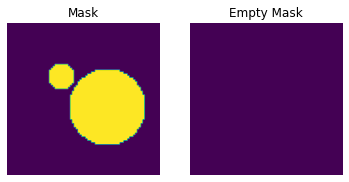

In [ ]:
#hide
# Generate an initial random image and mask with two circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 7, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2)
empty_mask = np.zeros_like(mask)
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(mask)
axs[0].set_axis_off()
axs[0].set_title('Mask')
axs[1].imshow(empty_mask)
axs[1].set_axis_off()
axs[1].set_title('Empty Mask');

In [ ]:
#export
def iou(a,b,threshold=0.5, average='macro', **kwargs):
    '''Computes the Intersection-Over-Union metric.'''
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if a.max()>1 or b.max()>1:
        return jaccard_score(a, b, average=average, **kwargs)
    else:
        a = np.array(a) > threshold
        b = np.array(b) > threshold
        overlap = a*b # Logical AND
        union = a+b # Logical OR
        return np.divide(np.count_nonzero(overlap),np.count_nonzero(union))

In [ ]:
# Test binary
test_eq(iou(mask, mask), 1)
test_eq(iou(mask, empty_mask), 0)

# Todo: add multiclass tests https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [ ]:
#export
def dice_score(*args, **kwargs):
    '''Computes the Dice coefficient metric.'''
    iou_score = iou(*args, **kwargs)
    return 2*iou_score/(iou_score+1)

In [ ]:
# Test binary
test_eq(dice_score(mask, mask), 1)
test_eq(dice_score(mask, empty_mask), 0)

## ROI-wise Analysis

In [ ]:
#export
def label_mask(mask, threshold=0.5, connectivity=4, min_pixel=15, do_watershed=False, exclude_border=False):
    '''Analyze regions and return labels'''
    if mask.ndim == 3:
        mask = np.squeeze(mask, axis=2)

    # apply threshold to mask
    # bw = closing(mask > threshold, square(2))
    bw = (mask > threshold).astype('uint8')

    # label image regions
    # label_image = label(bw, connectivity=2) # Falk p.13, 8-“connectivity”.
    _, label_image = cv2.connectedComponents(bw, connectivity=connectivity)

    # Watershed: Separates objects in image by generate the markers
    # as local maxima of the distance to the background
    if do_watershed:
        distance = ndimage.distance_transform_edt(bw)
        # Minimum number of pixels separating peaks in a region of `2 * min_distance + 1`
        # (i.e. peaks are separated by at least `min_distance`)
        min_distance = int(np.ceil(np.sqrt(min_pixel / np.pi)))
        local_maxi = peak_local_max(distance, indices=False, exclude_border=False,
                                    min_distance=min_distance, labels=label_image)
        markers = label(local_maxi)
        label_image = watershed(-distance, markers, mask=bw)

    # remove artifacts connected to image border
    if exclude_border:
        label_image = clear_border(label_image)

    # remove areas < min pixel
    unique, counts = np.unique(label_image, return_counts=True)
    label_image[np.isin(label_image, unique[counts<min_pixel])] = 0

    # re-label image
    label_image, _ , _ = relabel_sequential(label_image, offset=1)

    return label_image

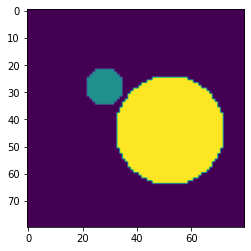

In [ ]:
tst_lbl_a = label_mask(mask, min_pixel=0)
test_eq(tst_lbl_a.max(), 2)
test_eq(tst_lbl_a.min(), 0)
plt.imshow(tst_lbl_a);

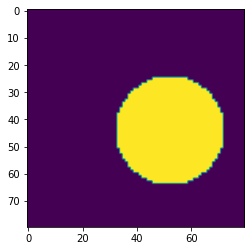

In [ ]:
tst_lbl_b = label_mask(mask, min_pixel=150)
test_eq(tst_lbl_b.max(), 1)
plt.imshow(tst_lbl_b);

In [ ]:
#export
def get_instance_segmentation_metrics(a, b, is_binary=False, thresholds=None, **kwargs):
    '''
    Computes instance segmentation metric based on cellpose/stardist implementation.
    https://cellpose.readthedocs.io/en/latest/api.html#cellpose.metrics.average_precision
    '''
    try: 
        from cellpose import metrics
    except:
        check_cellpose_installation()
        from cellpose import metrics
    
    # Find connected components in binary mask
    if is_binary:
        a = label_mask(a, **kwargs)
        b = label_mask(b, **kwargs)
        
    if thresholds is None:
        #https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
        thresholds = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
    
    ap, tp, fp, fn = metrics.average_precision(a, b, threshold=thresholds)
    
    return ap, tp, fp, fn

In [ ]:
# Test binary
ap, tp, fp, fn = get_instance_segmentation_metrics(mask, mask, is_binary=True)
test_eq(len(ap),10)
test_eq(tp[0],2)
ap, tp, fp, fn = get_instance_segmentation_metrics(mask, empty_mask, is_binary=True, thresholds=[.5])
test_eq(len(ap),1)
test_eq(fn[0],2)

2021-10-29 11:03:18,635 [INFO] WRITING LOG OUTPUT TO /media/data/home/mag01ud/.cellpose/run.log


## ROI Export to ImageJ

In [ ]:
#export
def export_roi_set(mask, intensity_image=None, instance_labels=False, name='RoiSet', path=Path('.'), ascending=True, min_pixel=0):
    "EXPERIMENTAL: Export mask regions to imageJ ROI Set"
    roifile = import_package('roifile')
    
    if not instance_labels:
        _, mask = cv2.connectedComponents(mask.astype('uint8'), connectivity=4)
    
    if intensity_image is not None:
        props = skimage.measure.regionprops_table(mask, intensity_image, properties=('area', 'coords', 'mean_intensity'))
        df_props = pd.DataFrame(props)
        df_props = df_props[df_props.area>min_pixel].sort_values('mean_intensity', ascending=ascending).reset_index()
    else:
        props = skimage.measure.regionprops_table(mask, properties=('area', 'coords'))
        df_props = pd.DataFrame(props).reset_index()
        df_props['mean_intensity'] = 1.
    
    i = 1
    with zipfile.ZipFile(path/f'{name}.zip', mode='w') as myzip:
        for _, row in df_props.iterrows():
            contours = skimage.measure.find_contours(mask==row['index']+1, level=0.5, fully_connected='low')
            for cont in contours: 
                roi_name = f'{i:04d}-{row.mean_intensity:3f}.roi'
                points = np.array([cont[:,1]+0.5, cont[:,0]+0.5]).T
                roi = roifile.ImagejRoi.frompoints(points)
                roi.tofile(roi_name)
                myzip.write(roi_name)    
                os.remove(roi_name)
                i += 1

In [ ]:
# EXPERIMENTAL, needs more testing
export_roi_set(mask)

## Miscellaneous

In [ ]:
#export
def calc_iterations(n_iter, ds_length, bs):
    "Calculate the number of required epochs for 'n_iter' iterations."
    iter_per_epoch = ds_length/bs
    return int(np.ceil(n_iter/iter_per_epoch))

In [ ]:
test_eq(calc_iterations(100, 8, 4), 50)

In [ ]:
#export
def get_label_fn(img_path, msk_dir_path):
    'Infers suffix from mask name and return label_fn'
    msk_path = [x for x in msk_dir_path.iterdir() if x.name.startswith(img_path.stem)]
    mask_suffix = msk_path[0].name[len(img_path.stem):]
    return lambda o: msk_dir_path/f'{o.stem}{mask_suffix}'

In [ ]:
#exports
def save_mask(mask, path, filetype='.png'):
    mask = mask.astype(np.uint8) if np.max(mask)>1 else (mask*255).astype(np.uint8)
    imageio.imsave(path.with_suffix(filetype), mask)

In [ ]:
#exports
def save_unc(unc, path, filetype='.png'):
    unc = (unc/unc.max()*255).astype(np.uint8)
    imageio.imsave(path.with_suffix(filetype), unc)

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
